# Lab 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numdifftools as ndt
from collections import deque
import time
import math
import tracemalloc


In [2]:
eps = 1e-6


In [3]:
def gen_f(n, k):
    m = np.random.rand(n, n) * 2
    Q, _ = np.linalg.qr(m)
    D = np.diag(np.array([k] + [1] * (n - 1)))

    result = Q @ D @ np.linalg.inv(Q)

    def f_impl(x):
        return x.T @ result @ x

    def f(x):
        return np.apply_along_axis(f_impl, 0, x)

    return f


def wolfe(f, x: np.ndarray, alpha, direction, c1=0.1, c2=0.9):
    gx = grad(f, x)
    cond1 = f(x + alpha * direction) <= f(x) + \
        alpha * c1 * np.dot(direction, gx)
    cond2 = abs(np.dot(direction, grad(f, x + alpha * direction))
                ) <= abs(c2 * np.dot(direction, gx))
    return cond1 and cond2


def find_wolfe(f, x: np.ndarray, direction):
    m = mk = 1
    start_alpha = 0.5
    for m in range(1, 10):
        alpha = start_alpha ** m
        if wolfe(f, x, alpha, direction):
            mk = m
            break
    return start_alpha ** mk


def grad(f, x: np.ndarray):
    g = ndt.Gradient(f)
    return g(x)

def jacobian(f, x: np.ndarray):
    j = ndt.Jacobian(f)
    return j(x)


def hessian(f, x: np.ndarray):
    h = ndt.Hessian(f)
    return h(x)


## Implementation

### Task 2: BFGS


In [4]:
def fast_bfgs_gd(f, x, lim=500):
    n = len(x)
    points = []
    g = None
    C = np.linalg.inv(hessian(f, x))
    points.append(x)
    while True:
        if g is None:
            g = grad(f, x)

        if np.linalg.norm(g) < eps:
            break

        p = -C @ g

        alpha = find_wolfe(f, x, p)
        delta = p * alpha
        x = x + delta
        points.append(x)

        if (len(points) > lim):
            break

        newg = grad(f, x)
        y = newg - g
        g = newg

        I = np.eye(n)
        rho = 1 / (y.T @ delta)
        C = (I - rho * np.outer(delta, y.T)) @ C @ (I - rho * np.outer(y, delta.T)) + \
            rho * np.outer(delta, delta.T)

    return np.array(points)


### Bonus task: L-BFGS

In [6]:
def l_bfgs_gd(f, x, m=8, lim=500):
    n = len(x)
    points = []
    rho_q = deque(maxlen=m)
    s_q = deque(maxlen=m)
    y_q = deque(maxlen=m)
    g = None
    points.append(x)
    while True:
        if g is None:
            g = grad(f, x)

        if np.linalg.norm(g) < eps:
            break

        alpha_q = []

        q = g
        for s, rho, y in zip(reversed(s_q), reversed(rho_q), reversed(y_q)):
            alpha = rho * np.outer(s.T, q)
            alpha_q.append(alpha)
            q = q - alpha @ y

        try:
            gamma = (s_q[-1].T @ y_q[-1]) / (y_q[-1].T @ y_q[-1])
            H = gamma * np.eye(n)
        except IndexError:
            H = np.linalg.inv(hessian(f, x))

        z = H @ q

        for s, rho, y, alpha in zip(s_q, rho_q, y_q, reversed(alpha_q)):
            beta = rho * np.outer(y.T, z)
            z = z + s @ (alpha - beta)

        p = -z
        alpha = find_wolfe(f, x, p)
        delta = p * alpha
        s_q.append(delta)
        x = x + delta
        points.append(x)

        if (len(points) > lim):
            break

        newg = grad(f, x)
        y = newg - g
        y_q.append(y)
        g = newg

        rho = 1 / (y.T @ delta)
        rho_q.append(rho)

    return np.array(points)


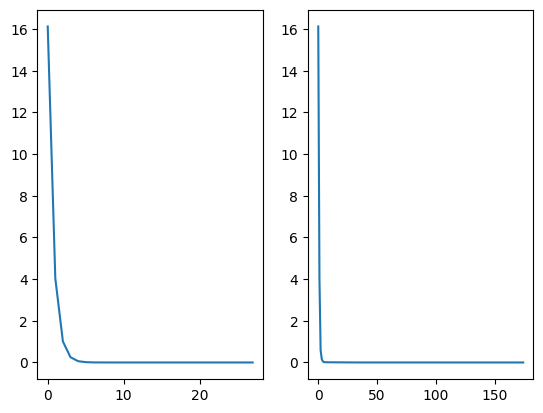

In [149]:
n = 20
k = 100

f = gen_f(n, k)
x = np.array([-0.1] * n)

fig, axs = plt.subplots(1, 2)
ax1, ax2 = axs

ax1.plot(list(map(f, fast_bfgs_gd(f, x))))
ax2.plot(list(map(f, l_bfgs_gd(f, x))))


## Comparison with other methods

In [8]:
def sgd(f, x, lr, lim=500):
    return momentum_gd(f, x, lr, 0, lim=lim)


def momentum_gd(f, x, lr, momentum, lim=500):
    n = len(x)
    points = []
    points.append(x)
    v = np.array([0] * len(x))

    while True:
        v = momentum * v - lr * (g := grad(f, x))

        if abs(f(x) - f(x + v)) < eps:
            break
        x = x + v

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)


def nesterov_gd(f, x, lr, momentum, lim=500):
    n = len(x)
    points = []
    points.append(x)
    v = np.array([0] * len(x))
    while True:
        v = momentum * v + (1 - momentum) * grad(f, x - lr * momentum * v)
        delta = - lr * v
        if abs(f(x) - f(x + delta)) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break
    return np.array(points)


def adagrad(f, x, lr, lim=500):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    G = 0
    while True:
        g = grad(f, x)
        G += np.dot(g, g)
        delta = - lr * g / np.sqrt(G + ee)
        if abs(f(x) - f(x + delta)) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)


def rmsprop(f, x, lr, beta, lim=500):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    s = 0
    while True:
        g = grad(f, x)
        s = s * beta + (1 - beta) * np.dot(g, g)
        delta = - lr * g / np.sqrt(s + ee)
        if abs(f(x) - f(x + delta)) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)


def adam(f, x, lr, beta1, beta2, lim=500):
    ee = 1e-8
    n = len(x)
    points = []
    points.append(x)
    s = 0
    v = np.array([0] * n)
    while True:
        g = grad(f, x)
        v = v * beta1 + (1 - beta1) * g
        s = s * beta2 + (1 - beta2) * np.dot(g, g)
        v_ = v / (1 - beta1 ** len(points))
        s_ = s / (1 - beta2 ** len(points))
        delta = - lr * v_ / np.sqrt(s_ + ee)
        if abs(f(x) - f(x + delta)) < eps:
            break
        x = x + delta

        points.append(x)

        if len(points) >= lim:
            break

    return np.array(points)


In [9]:
def best_sgd(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1]
    points = None
    for i in range(len(lrs)):
        new_points = sgd(
            f, x, lrs[i])
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i]

    return points


def best_momentum_gd(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = momentum_gd(
                f, x, lrs[i], coefs[j])
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i], coefs[j]

    return points


def best_nesterov_gd(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = nesterov_gd(
                f, x, lrs[i], coefs[j])
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i], coefs[j]

    return points


def best_adagrad(f, x):
    lrs = [0.05, 0.1, 0.5, 1.0, 2.0, 4.0, 8.0]
    points = None
    for i in range(len(lrs)):
        new_points = adagrad(
            f, x, lrs[i])
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i]

    return points


def best_rmsprop(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = rmsprop(
                f, x, lrs[i], coefs[j])
        if points is None or len(new_points) < points[0]:
            points = len(new_points), lrs[i], coefs[j]

    return points


def best_adam(f, x):
    points = None
    for lr in [0.1, 0.5, 1.0]:
        c1 = [0.8 + i / 40 for i in range(8)] + [0.999]
        c2 = [0.8 + i / 40 for i in range(8)] + [0.999]
        for i in range(len(c1)):
            for j in range(len(c2)):
                new_points = adam(
                    f, x, lr, c1[i], c2[j])
                if points is None or len(new_points) < points[0]:
                    points = len(new_points), lr, c1[i], c2[j]

    return points


def best_fast_bfgs(f, x):
    return None, 


def best_l_bfgs(f, x):
    return None, 


In [10]:
def timer(f, result=[0] * 4):
    start = time.time()
    tracemalloc.start()
    result[3] += len(f())
    memory_result = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tracemalloc.clear_traces()
    result[0] += time.time() - start
    result[1] += memory_result[0]
    result[2] += memory_result[1]
    return result

In [11]:
for n in [10, 100]:
    iters = 8 if n < 100 else 4
    xs = [np.random.rand(n) * 10 for _ in range(iters)]
    funcs = [gen_f(n, 1 + np.random.rand()) for _ in range(iters)]

    def print_result(name, result):
        print(f'\t{name}:')
        print(f'\t\tavg iterations: {result[3]}')
        print(f'\t\tavg time: {result[0]}')
        print(f'\t\tavg memory peak: {result[2]}')

    def collect_data(get_best, grad, name):
        result = [0] * 4
        args = get_best(funcs[0], xs[0])[1:]
        for iter in range(iters):
            timer(lambda: grad(funcs[iter], xs[iter], *args), result)
        result = list(map(lambda x: x / iters, result))
        print_result(name, result)

    print(f'n = {n}:')
    collect_data(best_sgd, sgd, 'SGD')
    collect_data(best_momentum_gd, momentum_gd, 'Momentum')
    collect_data(best_nesterov_gd, nesterov_gd, 'Nesterov')
    collect_data(best_adagrad, adagrad, 'AdaGrad')
    collect_data(best_rmsprop, rmsprop, 'RMSProp')
    collect_data(best_adam, adam, 'Adam')
    collect_data(best_fast_bfgs, fast_bfgs_gd, 'Fast BFGS')
    collect_data(best_l_bfgs, l_bfgs_gd, 'L-BFGS')


n = 10:
	SGD:
		avg iterations: 40.625
		avg time: 1.3262710571289062
		avg memory peak: 62891.875
	Momentum:
		avg iterations: 151.75
		avg time: 5.236130744218826
		avg memory peak: 134325.75
	Nesterov:
		avg iterations: 24.125
		avg time: 0.7807751297950745
		avg memory peak: 51473.25
	AdaGrad:
		avg iterations: 32.375
		avg time: 1.0476489663124084
		avg memory peak: 56031.5
	RMSProp:
		avg iterations: 24.25
		avg time: 0.8037396669387817
		avg memory peak: 46835.125
	Adam:
		avg iterations: 86.75
		avg time: 2.7100407481193542
		avg memory peak: 92852.75
	Fast BFGS:
		avg iterations: 27.125
		avg time: 2.7765467762947083
		avg memory peak: 161006.25
	L-BFGS:
		avg iterations: 27.5
		avg time: 2.8235543072223663
		avg memory peak: 165899.875
n = 100:
	SGD:
		avg iterations: 46.25
		avg time: 14.498641848564148
		avg memory peak: 238951.0
	Momentum:
		avg iterations: 155.0
		avg time: 48.41385865211487
		avg memory peak: 376662.0
	Nesterov:
		avg iterations: 32.0
		avg time: 9.95842

In [12]:
def best_sgd(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1]
    points = None
    for i in range(len(lrs)):
        new_points = sgd(
            f, x, lrs[i])
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_momentum_gd(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = momentum_gd(
                f, x, lrs[i], coefs[j])
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_nesterov_gd(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = nesterov_gd(
                f, x, lrs[i], coefs[j])
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_adagrad(f, x):
    lrs = [0.05, 0.1, 0.5, 1.0, 2.0, 4.0, 8.0]
    points = None
    for i in range(len(lrs)):
        new_points = adagrad(
            f, x, lrs[i])
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_rmsprop(f, x):
    lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    coefs = [i / 10 for i in range(1, 10)]
    points = None
    for i in range(len(lrs)):
        for j in range(len(coefs)):
            new_points = rmsprop(
                f, x, lrs[i], coefs[j])
        if points is None:
            points = new_points
            continue
        points = min(new_points, points, key=len)

    return points


def best_adam(f, x):
    points = None
    for lr in [0.1, 0.5, 1.0]:
        c1 = [0.8 + i / 40 for i in range(8)] + [0.999]
        c2 = [0.8 + i / 40 for i in range(8)] + [0.999]
        for i in range(len(c1)):
            for j in range(len(c2)):
                new_points = adam(
                    f, x, lr, c1[i], c2[j])
                if points is None:
                    points = new_points
                    continue
                points = min(new_points, points, key=len)

    return points

def best_true_bfgs(f, x):
    return true_bfgs_gd(f, x), 


def best_fast_bfgs(f, x):
    return fast_bfgs_gd(f, x), 


def best_l_bfgs(f, x):
    return l_bfgs_gd(f, x), 


SGD: 35


Momentum: 154
Nesterov: 41
AdaGrad: 21
RMSProp: 17
Adam: 57
BFGS: 27
L-BFGS: 33
-5.5 2.7419993152801982 6.170931207266506 -5.696170156353631


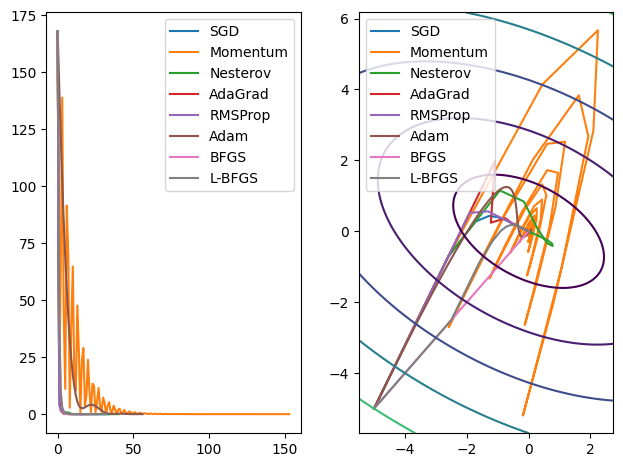

In [13]:
n = 2
lr = 0.1
x = np.array([-5] * n)
bs = 2
f = gen_f(n, 3 + np.random.rand())

fig, axs = plt.subplots(1, 2)
fig.tight_layout()
ax1, ax2 = axs

inf = float('inf')
lm, rm, tm, bm = inf, -inf, -inf, inf

points = best_sgd(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("SGD:", len(points))

points = best_momentum_gd(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("Momentum:", len(points))

points = best_nesterov_gd(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("Nesterov:", len(points))

points = best_adagrad(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("AdaGrad:", len(points))

points = best_rmsprop(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("RMSProp:", len(points))

points = best_adam(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("Adam:", len(points))

points = fast_bfgs_gd(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("BFGS:", len(points))

points = l_bfgs_gd(f, x)
for p in points:
    lm = min(lm, p[0])
    rm = max(rm, p[0])
    tm = max(tm, p[1])
    bm = min(bm, p[1])
ax1.plot(list(map(f, points)))
ax2.plot(points[:, 0], points[:, 1])
print("L-BFGS:", len(points))

lm -= 0.5
rm += 0.5
tm += 0.5
bm -= 0.5

print(lm, rm, tm, bm)

X, Y = np.meshgrid(np.linspace(lm, rm, 100), np.linspace(bm, tm, 100))
ax2.contour(X, Y, f([X, Y]), levels=sorted([f(np.array([p, p])) for p in range(1, math.ceil(max(abs(lm), abs(rm), abs(tm), abs(bm))))]))

ax1.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam', 'BFGS', 'L-BFGS'])
ax2.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam', 'BFGS', 'L-BFGS'])

64
501


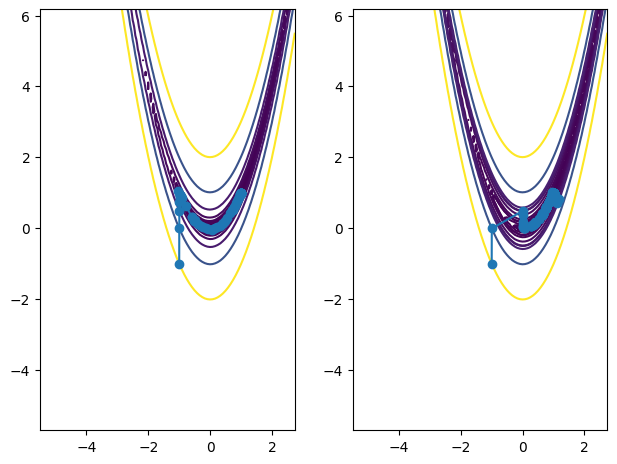

In [155]:
def f(x): # Rosenbrock function
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2

x = np.array([-1,-1])
def plot(plt, points):
    print(len(points))
    plt.contour(X, Y, f([X, Y]), levels=sorted([f(p) for p in points]))
    plt.plot(points[:, 0], points[:, 1], 'o-')


fig, axs = plt.subplots(1, 2)
fig.tight_layout()
ax1, ax2 = axs

plot(ax1, fast_bfgs_gd(f, x))
plot(ax2, l_bfgs_gd(f, x))

### Task 1: Regression Methods

#### Implementation

In [143]:
def gauss_newton(p, points, num_iters=100):
        w = np.zeros(p+1)
        A = np.array([[x ** i for i in range(p + 1)] for x in points[:, 0]])
        x = points[:, 0]
        y = points[:, 1]
        r = lambda w: y - np.array(sum(w[i] * x ** i for i in range(p + 1)))
        err = lambda w: sum(map(lambda ri: ri ** 2, r(w)))
        for cnt in range(num_iters):
            J = jacobian(r, w)

            delta = -(np.linalg.inv(J.T @ J) @ J.T @ r(w))
            
            prev_err = err(w)
            w += delta 
            # print(sum(w[i] * x ** i for i in range(p + 1)))

            if abs(err(w) - prev_err) < 1e-5:
                break

        return w, cnt

def dog_leg(p, points, trust_region=0.1, num_iters=100):
    def step(J, r: np.ndarray):
        gn_delta = -np.linalg.inv(J.T @ J) @ J.T @ r # gauss-newton
        if np.linalg.norm(gn_delta) <= trust_region:
            return gn_delta
        
        st_delta = -J.T @ r # gradient descent
        if np.linalg.norm(st_delta) > trust_region:
            return st_delta / np.linalg.norm(st_delta) * trust_region

        t = (np.linalg.norm(st_delta) / np.linalg.norm(J @ st_delta)) ** 2
        return t * st_delta + trust_region * (gn_delta - t * st_delta)
    
    w = np.zeros(p+1)
    A = np.array([[x ** i for i in range(p + 1)] for x in points[:, 0]])
    x = points[:, 0]
    y = points[:, 1]
    r = lambda w: y - np.array(sum(w[i] * x ** i for i in range(p + 1)))
    err = lambda w: sum(map(lambda ri: ri ** 2, r(w)))
    for cnt in range(num_iters):
        J = jacobian(r, w)

        delta = step(J, r(w))

        prev_err = err(w)
        w += delta 

        if abs(err(w) - prev_err) < 1e-5:
            break


    return w, cnt

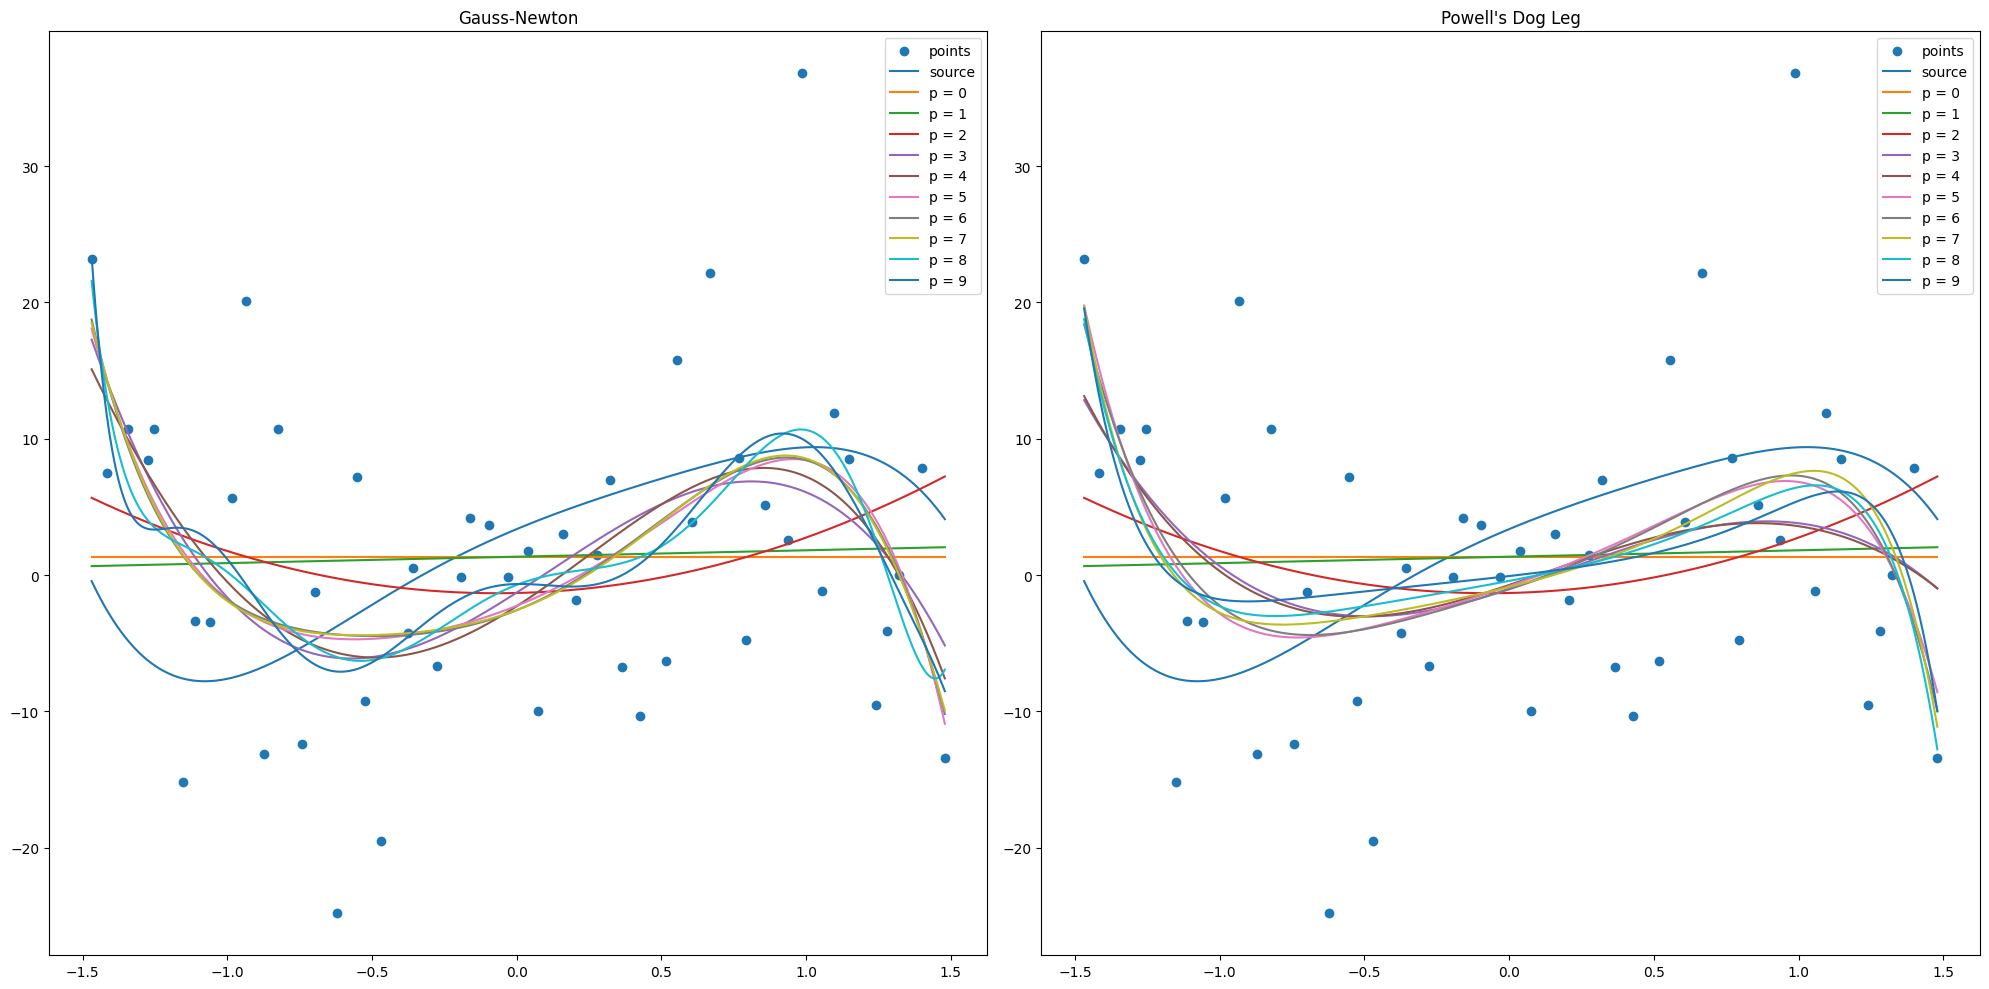

In [144]:
def gen_points(p, count, disp):
    poly = [(-0.5 + float(np.random.rand())) * 20 for i in range(p + 1)]

    def calc(x): return sum(poly[i] * x **
                            i for i in range(p + 1)) + np.random.normal(scale=disp)

    return np.array(sorted([(x := 0.05 * np.random.rand() + (i - count / 2) / (count / 3), calc(x)) for i in range(count)], key=lambda x: x[0]))


def gen_points_with_source(p, count, disp):
    poly = [(-0.5 + float(np.random.rand())) * 20 for i in range(p + 1)]

    def calc(x): return sum(poly[i] * x **
                            i for i in range(p + 1)) + np.random.normal(scale=disp)

    return np.array(sorted([(x := 0.05 * np.random.rand() + (i - count / 2) / (count / 3), calc(x)) for i in range(count)], key=lambda x: x[0])), poly


def plot_regr(points, source, ax, reg, regname):
    ax.scatter(points[:, 0], points[:, 1])
    def src(x): 
        return sum(x ** i * source[i] for i in range(len(source)))
    src = np.vectorize(src)
    X = np.linspace(min(points[:, 0]), max(points[:, 0]), 1000)
    ax.plot(X, src(X))
    
    itercounts = []
    ps = 10
    for p in range(ps):
        poly, cnt = reg(p, points)
        itercounts.append(cnt)
        def y(x): return sum(x ** i * poly[i] for i in range(p + 1))

        X = np.linspace(min(points[:, 0]), max(points[:, 0]), 1000)
        ax.plot(X, y(X))

    ax.set_title(f'{regname}')
    ax.legend(['points', 'source'] + [f'p = {i}' for i in range(ps)])


points, source = gen_points_with_source(5, 50, 10)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plot_regr(points, source, axs[0], gauss_newton, f"Gauss-Newton")
plot_regr(points, source, axs[1], dog_leg, f"Powell's Dog Leg")
fig.tight_layout()

#### Comparison

In [145]:
def elastic_regression(p, ps, alpha=0.5, lda=1):
    def rmsprop_loss_f(x, bs, lr, beta, lim=500, eps_mode=False):
        def loss_diff(x, i):
            return 2 / len(ps) * sum((sum(ps[k][0] ** j * x[j] for j in range(p + 1)) - ps[k][1]) * ps[k][0] ** i for k in range(len(ps))) + lda * (alpha + (1 - alpha) * x[i])

        def grad(x):
            g = np.array([0.0] * (p + 1))
            for i in range(len(x)):
                g[i] += loss_diff(x, i)
            return g

        ee = 1e-6
        n = len(x)
        points = []
        points.append(x)
        s = 0
        if eps_mode:
            while True:
                g = grad(x)
                s = s * beta + (1 - beta) * np.dot(g, g)
                delta = - lr * g / np.sqrt(s + ee)
                x = x + delta

                points.append(x)

                if len(points) > lim:
                    return np.array(points)
        else:
            for _ in range(lim):
                g = grad(x)
                s = s * beta + (1 - beta) * np.dot(g, g)
                delta = - lr * g / np.sqrt(s + ee)
                x = x + delta
                if np.linalg.norm(delta) < eps:
                    break
                points.append(x)

        return np.array(points)

    x = np.array([0.0] * (p + 1))
    points = rmsprop_loss_f(x, 1, 1.0, 0.99, lim=500)
    return points[-1], len(points)

def poly_regression(p, points):
    return elastic_regression(p, points, 0, 0)

def l1_regression(p, points, lda=1):
    return elastic_regression(p, points, 0, lda)


def l2_regression(p, points, lda=1):
    return elastic_regression(p, points, 1, lda)


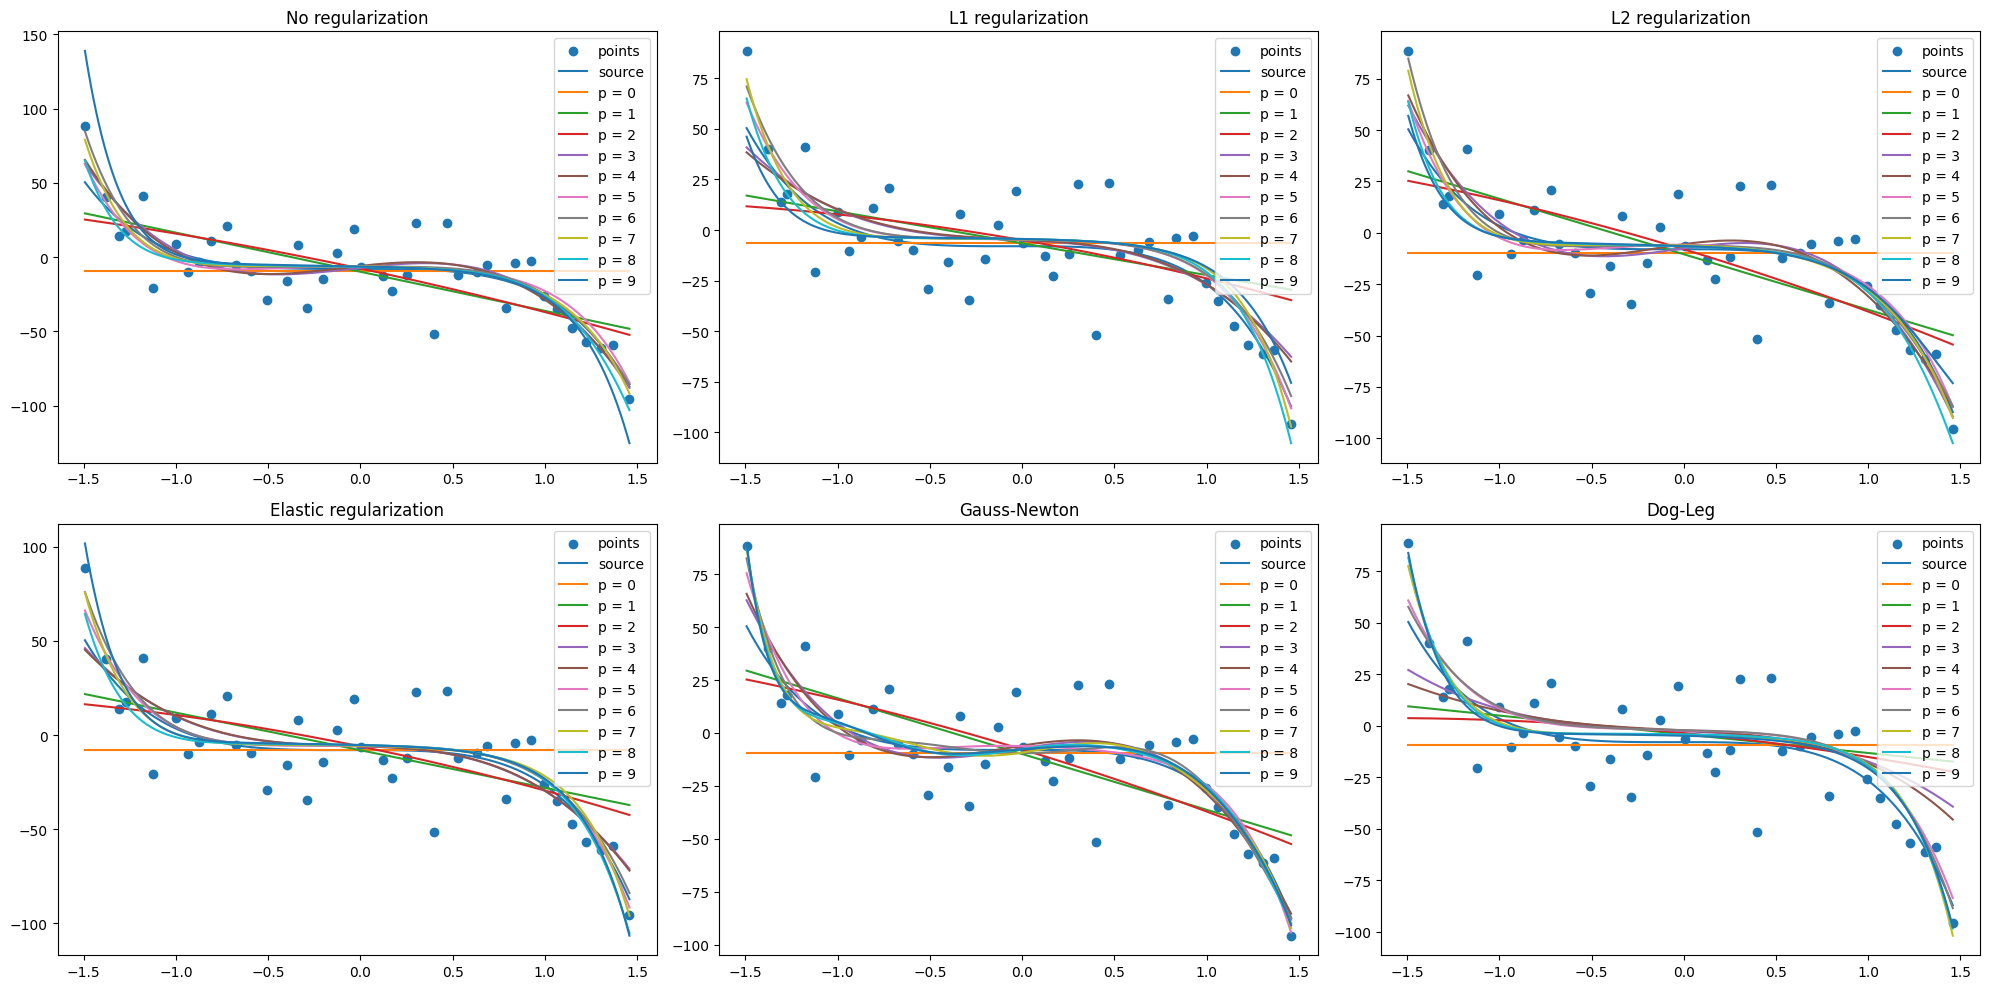

In [146]:
points, source = gen_points_with_source(5, 40, 20)
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for ax, reg, regname in zip(axs.flatten(),
                               [poly_regression, l1_regression,
                                   l2_regression, elastic_regression, 
                                   gauss_newton, dog_leg],
                               ["No regularization", "L1 regularization", "L2 regularization", "Elastic regularization", "Gauss-Newton", "Dog-Leg"]):
    plot_regr(points, source, ax, reg, regname)
fig.tight_layout()

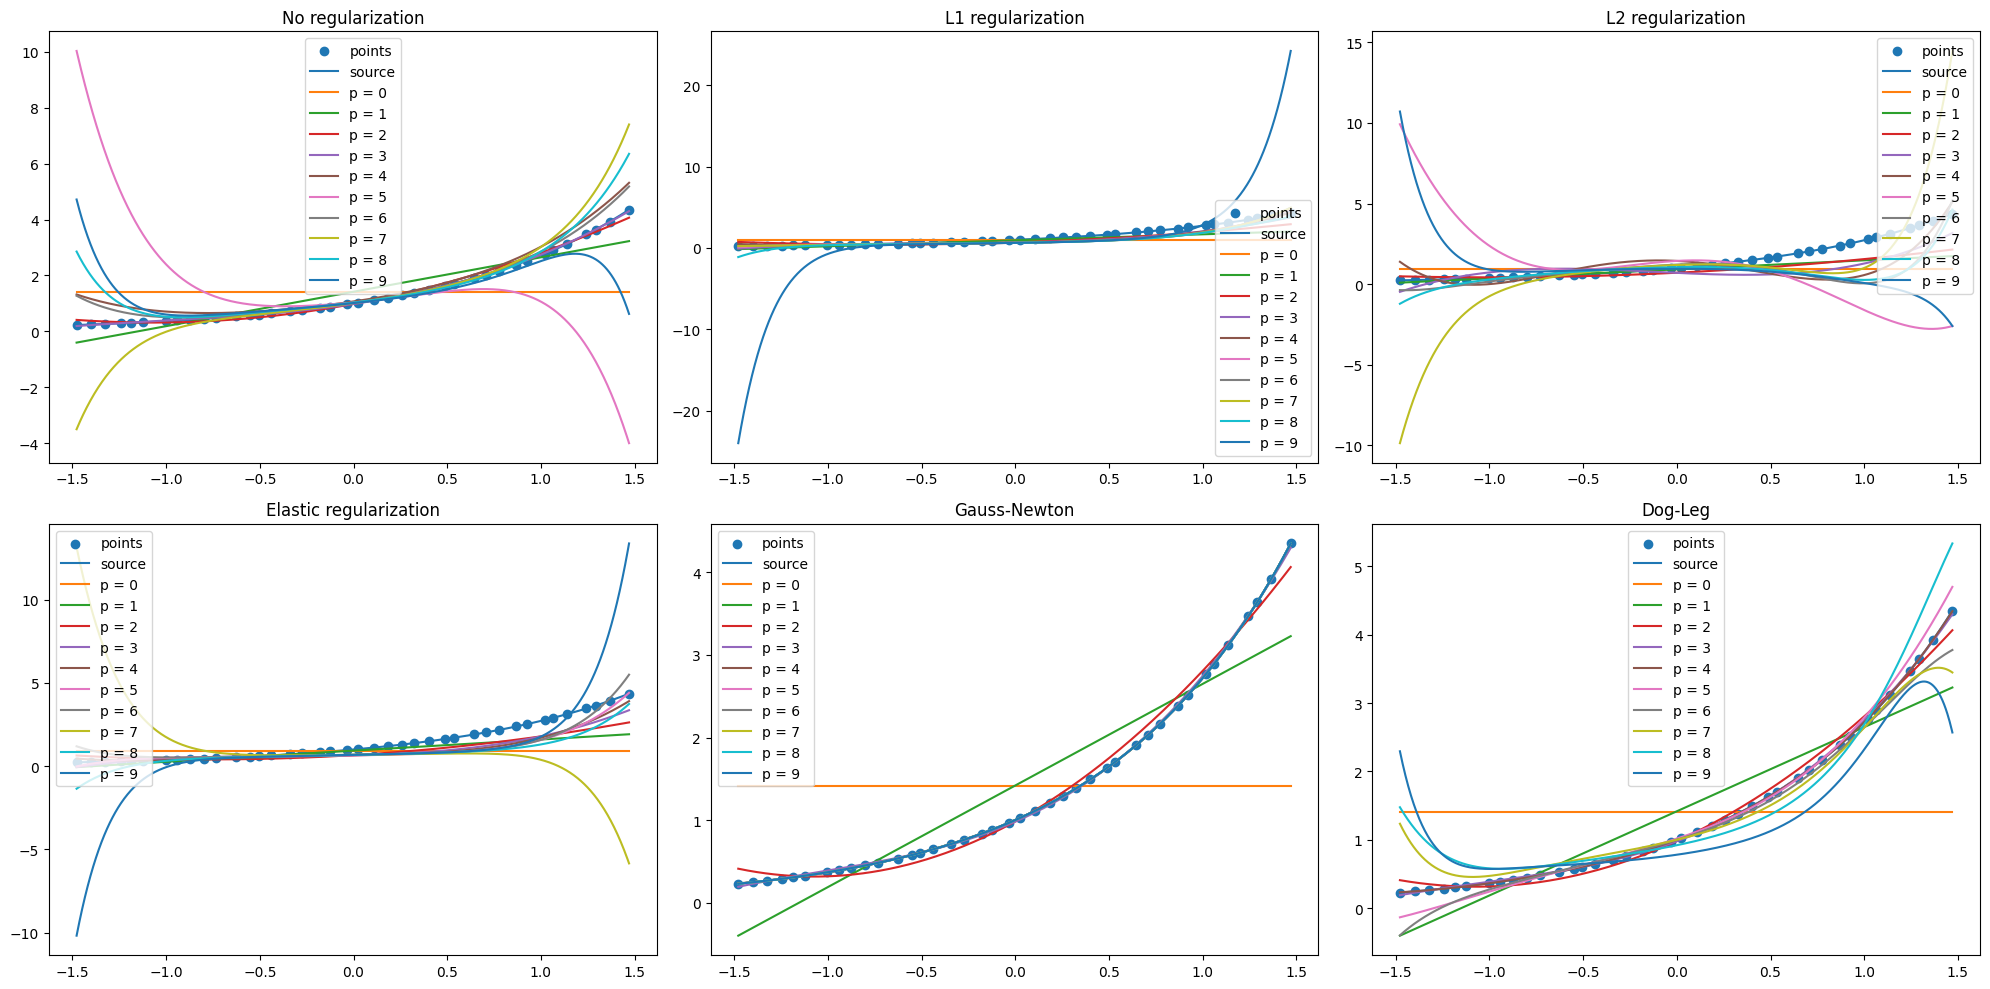

In [148]:
def gen_points_with_source_f(p, count, disp, calc):
    return np.array(sorted([(x := 0.05 * np.random.rand() + (i - count / 2) / (count / 3), calc(x)) for i in range(count)], key=lambda x: x[0])), calc

def plot_regr_f(points, src, ax, reg, regname):
    ax.scatter(points[:, 0], points[:, 1])

    X = np.linspace(min(points[:, 0]), max(points[:, 0]), 1000)
    ax.plot(X, src(X))
    
    itercounts = []
    ps = 10
    for p in range(ps):
        poly, cnt = reg(p, points)
        itercounts.append(cnt)
        def y(x): return sum(x ** i * poly[i] for i in range(p + 1))

        X = np.linspace(min(points[:, 0]), max(points[:, 0]), 1000)
        ax.plot(X, y(X))

    ax.set_title(f'{regname}')
    ax.legend(['points', 'source'] + [f'p = {i}' for i in range(ps)])

points, source = gen_points_with_source_f(5, 40, 20, np.exp)
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for ax, reg, regname in zip(axs.flatten(),
                               [poly_regression, l1_regression,
                                   l2_regression, elastic_regression, 
                                   gauss_newton, dog_leg],
                               ["No regularization", "L1 regularization", "L2 regularization", "Elastic regularization", "Gauss-Newton", "Dog-Leg"]):
    plot_regr_f(points, np.exp, ax, reg, regname)
fig.tight_layout()